#### Coding Discussion 5
Carmen Wang 

In [71]:
import pandas as pd
import numpy as np
import scipy.stats as st
import pprint as pp 
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns 
import matplotlib.pyplot as plt
from plotnine import * 
from sklearn.naive_bayes import GaussianNB # Classifier 
import sklearn.metrics as m

In [2]:
#import data 
dta = pd.read_csv('turnout.csv')
dta

,id,age,educate,income,vote,white
0,1,60,14.0,3.3458,1,1
1,2,51,10.0,1.8561,0,1
2,3,24,12.0,0.6304,0,1
3,4,38,8.0,3.4183,1,1
4,5,25,12.0,2.7852,1,1
...,...,...,...,...,...,...
1995,1996,26,16.0,3.3834,0,1
1996,1997,34,12.0,2.9170,1,1
1997,1998,51,16.0,7.8949,1,1
1998,1999,22,10.0,2.4811,0,1


In [73]:
#set seed to generate random sample 
np.random.seed(1234)

#split the data into training and testing data 

training = dta.sample(frac=0.8).reset_index(drop=True)
testing = dta.drop(training.index).reset_index(drop=True)

In [74]:
#count the split 
print(training.shape, testing.shape)

(1600, 6) (400, 6)


In [75]:
#calculate class probability 
N = training.shape[0]

vote0 = training.query("vote == 0")
vote1 = training.query("vote == 1")

pr_v_0 = vote0.shape[0]/N
pr_v_1 = vote1.shape[0]/N

print(
f"""
Pr(vote = 0): {pr_v_0}
Pr(vote = 1): {pr_v_1}
""")


Pr(vote = 0): 0.2575
Pr(vote = 1): 0.7425



In [76]:
#ID won't be used for prediction
training.drop('id', axis = 1, inplace = True)
testing.drop('id', axis = 1, inplace = True)

#### Conditional Probability
- $Pr(white = 1 | vote = 1)$
- $Pr(white = 0 | vote = 1)$
- $Pr(white = 1 | vote = 0)$
- $Pr(white = 0 | vote = 0)$


In [77]:
#given vote = 1

pr_w1_v1 = vote1.query("white == 1").shape[0]/vote1.shape[0]
pr_w0_v1 = vote1.query("white == 0").shape[0]/vote1.shape[0]
pr_w1_v0 = vote0.query("white == 1").shape[0]/vote0.shape[0]
pr_w0_v0 = vote0.query("white == 0").shape[0]/vote0.shape[0]

print(
f"""
Pr(white = 1|vote = 1): {pr_w1_v1}
Pr(white = 0|vote = 1): {pr_w0_v1}
Pr(white = 1|vote = 1): {pr_w1_v0}
Pr(white = 0|vote = 0): {pr_w0_v0}
"""
)


Pr(white = 1|vote = 1): 0.8686868686868687
Pr(white = 0|vote = 1): 0.13131313131313133
Pr(white = 1|vote = 1): 0.7985436893203883
Pr(white = 0|vote = 0): 0.20145631067961164



In [79]:
white_pr = \
{('white', 1, 1): pr_w1_v1,
 ('white', 0, 1): pr_w0_v1,
 ('white', 1, 0): pr_w1_v0,
 ('white', 0, 0): pr_w0_v0
}

#### continuous variable 

In [80]:
#calculate mean and stdv for each continuous variable 

dist_locs = \
{("age",1):{'mean':vote1.age.mean(),'sd':vote1.age.std()},
 ("age",0):{'mean':vote0.age.mean(),'sd':vote0.age.std()},
 ("educate",1):{'mean':vote1.educate.mean(),'sd':vote1.educate.std()},
 ("educate",0):{'mean':vote0.educate.mean(),'sd':vote0.educate.std()},
 ("income",1):{'mean':vote1.income.mean(),'sd':vote1.income.std()},
 ("income",0):{'mean':vote0.income.mean(),'sd':vote0.income.std()},
}


pp.pprint(dist_locs)

{('age', 0): {'mean': 42.601941747572816, 'sd': 19.147825402160812},
 ('age', 1): {'mean': 46.32491582491583, 'sd': 16.924844588853727},
 ('educate', 0): {'mean': 10.62864077669903, 'sd': 3.3043810919835317},
 ('educate', 1): {'mean': 12.558922558922559, 'sd': 3.2957141274443202},
 ('income', 0): {'mean': 2.738161893203883, 'sd': 2.242991372933763},
 ('income', 1): {'mean': 4.229461952861953, 'sd': 2.848208991067699}}


Text(0, 0.5, 'Distribution')

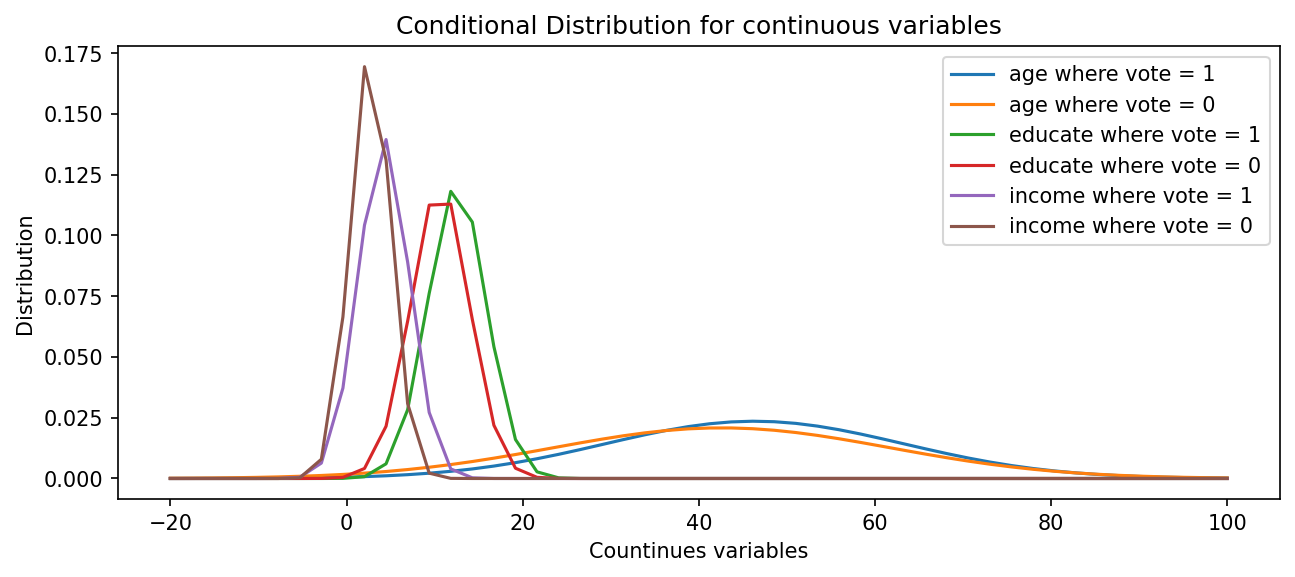

In [81]:
#plot the conditional distribution

plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-20,100)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where vote = {key[1]}")
plt.title("Conditional Distribution for continuous variables")
plt.xlabel("Countinues variables")
plt.ylabel("Distribution")

#### Prediction 
Outcome:
- $Pr(vote = 1 | X)$
- $Pr(vote = 0 | X)$

In [82]:
def predict(data,dist_locs, binary, binary_pr):
    '''
    Function:    predict an outcome 
    Aurgument:   data: data input for prediction
                 dist_locs: dictionary of conditional probability of continuous variables 
                 binary: a list of binary variable(s)
                 binary_pr: dictionary of conditional probability of the binary variable(s)
    '''
    store_preds = []
    for i,row in data.iterrows():
        
        #initialize the class probability 
        pr_0 = 1; pr_1 = 1
        for j in range(1,len(row)):
            
            if row.index[j] in binary:
                    pr_0 *= binary_pr[(row.index[j],row.values[j],0)]
                    pr_1 *= binary_pr[(row.index[j],row.values[j],1)] 
            #for continuous variables 
            else: 
                    pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
                    pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_v_0
        pr_1 *= pr_v_1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run the function 
preds_train = predict(training.drop("vote", axis = 1), dist_locs, ['white'], white_pr)

In [55]:
preds_train.head(10)

,pr_0,pr_1,pred
0,0.000963,0.003754,1
1,0.000051,0.000011,0
2,0.003544,0.004789,1
3,0.002531,0.002372,0
4,0.002616,0.008924,1
5,0.000372,0.000165,0
6,0.003906,0.008219,1
7,0.001142,0.006008,1
8,0.001829,0.003999,1
9,0.002200,0.009923,1


In [57]:
#acuracy for training data
accuracy_train = sum(training.vote == preds_train.pred)/training.shape[0]
accuracy_train

0.73125

In [60]:
#accuracy for testing data 
preds_test = predict(testing.drop("vote", axis = 1), dist_locs, ['white'], white_pr)
accuracy_test = sum(testing.vote == preds_test.pred)/testing.shape[0]
accuracy_test

0.7075

####  `sklearn` implementation 

In [65]:
train_y = training['vote']
train_x = training[['age','educate','income','white']]
test_y = testing['vote']
test_x = testing[['age','educate','income','white']]

gnb = GaussianNB()
gnb.fit(train_x, train_y) # Train

# Predict 
y_pred = gnb.predict(test_x)

# Out-of-sample performance 
m.accuracy_score(test_y,y_pred)

0.7125

In [66]:
m.roc_auc_score(test_y,y_pred)

0.575595238095238

In [84]:
#to plot ROC curve
#get the probability 
probs = gnb.predict_proba(test_x)
probs =  pd.DataFrame(probs,columns=gnb.classes_)
probs


,0,1
0,0.382004,0.617996
1,0.089185,0.910815
2,0.275975,0.724025
3,0.255162,0.744838
4,0.036055,0.963945
...,...,...
395,0.168330,0.831670
396,0.274707,0.725293
397,0.021379,0.978621
398,0.438499,0.561501


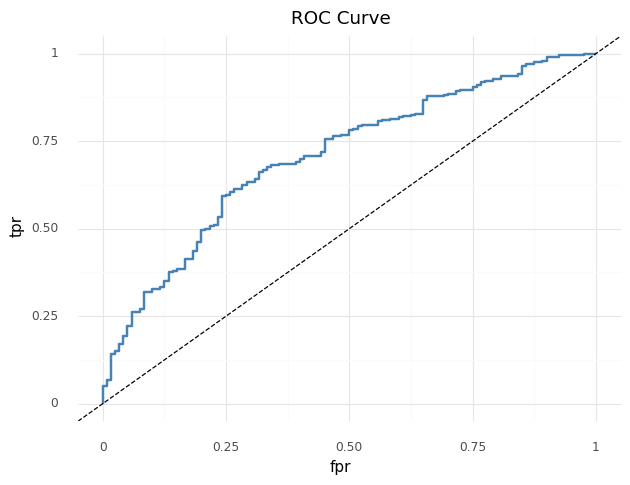

<ggplot: (-9223371913239109593)>

In [85]:
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(7,5))
)

#### Summary 

Our model has an accuracy rate of 70.75% in the testing data. Generally speaking, the model makes pretty good predictions, and our model is better than chance. 

AUC score is 57.56%, which is slightly over 50%. In the other words, the prediction is not less than a satisfactory level. 
